## import libraries

In [1]:
import os
import sys
from tqdm import tqdm
from time import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from sklearn import datasets
from sklearn.manifold import TSNE

sys.path.append("../")

# Network architectures
from net.resnet import resnet50
from net.vgg import vgg16

from data_utils.ood_detection import cifar10,svhn
import metrics.uncertainty_confidence as uncertainty_confidence
from utils.gmm_utils import get_embeddings, gmm_fit, gmm_evaluate

## load model

In [2]:
device = "cuda:1" if torch.cuda.is_available() else "cpu"
# Load ResNet model
model = vgg16(spectral_normalization=True,
                             mod = True,
                             mnist = False).to(device)
model.load_state_dict(torch.load("../saved_models/run8/vgg16_sn_3.0_mod_seed_1_contrastive3/2024_04_26_15_10_24/vgg16_sn_3.0_mod_seed_1_contrastive3_best.model"))
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = input[0]
    return hook

model.fc.register_forward_hook(get_activation('embedding'))

In [3]:
num_classes = 10
batch_size = 128

# MNIST data loader
train_loader,val_loader = cifar10.get_train_valid_loader(batch_size,True,1,0.01,root="../data/")
ood_test_loader = svhn.get_test_loader(batch_size,root="../data/")
Xs = []
ys = []
for images,_ in tqdm(ood_test_loader):
    labels = np.ones(images.shape[0])*10 #标记label=10为OOD样本
    images = images.to(device)
    model(images)
    embeddings = activation["embedding"]
    Xs.append(embeddings.cpu().detach().numpy())
    ys.append(labels)
    
for images,labels in tqdm(train_loader):
    images = images.to(device)
    model(images)
    embeddings = activation["embedding"]
    Xs.append(embeddings.cpu().detach().numpy())
    ys.append(labels.detach().numpy())

Using downloaded and verified file: ../data/svhn/test_32x32.mat


100%|██████████| 387/387 [00:18<00:00, 21.48it/s]


In [4]:
X = np.concatenate(Xs)
y = np.concatenate(ys)

## t-SNE Visualization

In [5]:
def plot_embedding_2d(X, y, num_classes, title):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    fig, axes = plt.subplots(1,2, figsize=(10, 5))
    
    # plt.scatter(X[:,0], X[:,1], c = y, s = 5, cmap = plt.cm.Spectral)

    cmap = plt.get_cmap('tab20')
    colors = []
    for i in range(13):
        colors.append(np.array(cmap(i)).reshape(1,-1))

    for i in range(num_classes):  # 对每类的数据画上特定颜色的点
        index = (y == i)
        axes[0].scatter(X[index, 0], X[index, 1], s=3, c=colors[i])
    axes[0].legend([i for i in range(num_classes)])
    for i in range(num_classes+1):  # 对每类的数据画上特定颜色的点
        index = (y == i)
        axes[1].scatter(X[index, 0], X[index, 1], s=3, c=colors[i])
    axes[1].legend([i for i in range(num_classes+1)])
    
    plt.tight_layout()
    return fig

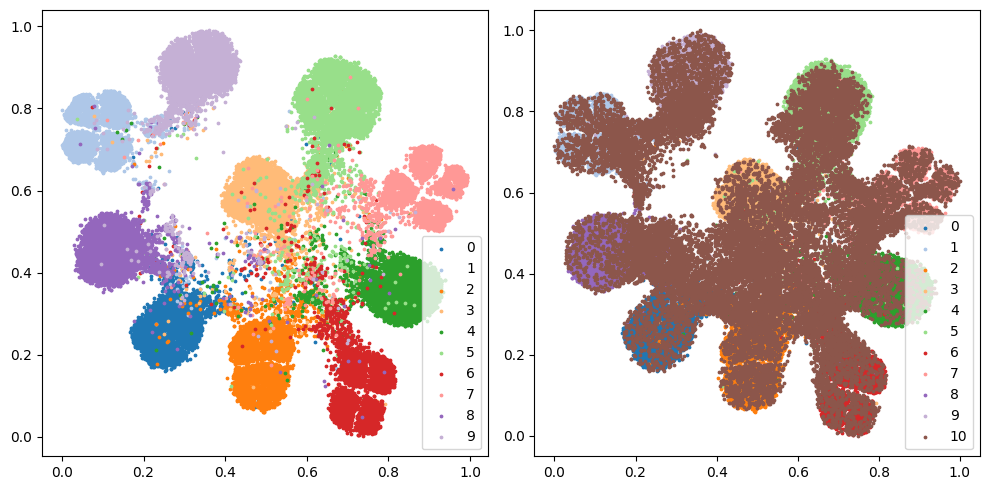

In [6]:
tsne = TSNE(n_components=2, init='pca', random_state=0,perplexity=100)
X_tsne = tsne.fit_transform(X)
_ = plot_embedding_2d(X_tsne,y,10,"t-SNE 2D")

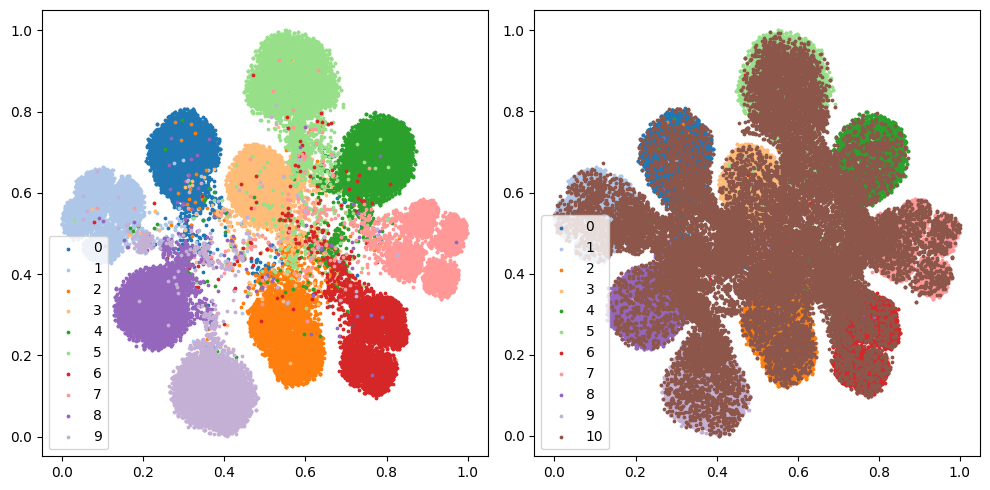

In [7]:
tsne = TSNE(n_components=2, init='pca', random_state=0,perplexity=30)
X_tsne = tsne.fit_transform(X)
_ = plot_embedding_2d(X_tsne,y,10,"t-SNE 2D")